In [4]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
from defs import regularAtlmask

In [40]:
datafolder = ''

In [6]:
experiment = 'E280' 
model = 'COSMOS'
folder = datafolder+'Raw_data/'+model+'/'

In [7]:
if experiment == 'E280':
    dsV = xr.open_dataset(folder+experiment+'/COSMOS_E280.vo_2650-2749_annual_climatology_remapcon_1x1deg.nc')
    dsT = xr.open_dataset(folder+experiment+'/COSMOS_E280.thetao_2650-2749_annual_climatology_remapcon_1x1deg.nc')
    dsS = xr.open_dataset(folder+experiment+'/COSMOS_E280.sao_2650-2749_annual_climatology_remapcon_1x1deg.nc')
    dsice = xr.open_dataset(folder+experiment+'/E280.SeaIceAreaFraction_CMIP6_name_sic_2650-2749_monthly_mean_time_series_remapbil.nc')
    dsr = xr.open_dataset(folder+experiment+'/BEK_PI_360x180.nc')
    dsMOC = xr.open_dataset(folder+experiment+'/E280.AMOC_CMIP6_name_NA_2650-2749_annual_mean_time_series.nc')
    dsOHT = xr.open_dataset(folder+experiment+'/E280_implied_heat_transport_AtlArc_2650-2749.nc')
elif experiment == 'Eoi400':
    dsV = xr.open_dataset(folder+experiment+'/COSMOS_Eoi400.vo_2650-2749_annual_climatology_remapcon_1x1deg.nc')
    dsT = xr.open_dataset(folder+experiment+'/COSMOS_Eoi400.thetao_2650-2749_annual_climatology_remapcon_1x1deg.nc')
    dsS = xr.open_dataset(folder+experiment+'/COSMOS_Eoi400.sao_2650-2749_annual_climatology_remapcon_1x1deg.nc')
    dsice = xr.open_dataset(folder+experiment+'/Eoi400.SeaIceAreaFraction_CMIP6_name_sic_2650-2749_monthly_mean_time_series_remapbil.nc')
    dsr = xr.open_dataset(folder+experiment+'/BEK_Plio_360x180.nc')
    dsMOC = xr.open_dataset(folder+experiment+'/Eoi400.AMOC_CMIP6_name_NA_2650-2749_annual_mean_time_series.nc')
    dsOHT = xr.open_dataset(folder+experiment+'/Eoi400_implied_heat_transport_AtlArc_2650-2749.nc')

## Separation MOC and gyre OHT component 100-yr average

In [10]:
vvel = dsV.vo[0]*100 #vvel in cm/s
temp = dsT.thetao[0] #temp in degC

#Atlantic Ocean region
region = dsr.THO[0,0]

In [11]:
## Create dz and dx arrays for integration

ds = dsT.copy(deep=True)

#1-D array with spacing of depth grid
dz = np.zeros(len(ds.lev))
dz[0] = ds.lev[0].values*2
depth = dz[0]
for i in range(1,len(ds.lev)):
    dz[i] = (ds.lev[i].values-depth)*2
    depth = depth+dz[i]
dz = dz*100 #Depth spacing. Units: cm
ds['dz'] = xr.DataArray(data=dz, dims=("lev"))
dz = ds.dz

#2-D array with spacing of horizontal UV grid
r = 6.37122e8 #radius Earth in cm
dlon = np.deg2rad((ds.lon[2]-ds.lon[1]))*r*np.cos(np.deg2rad(ds.lat)) #Lon spacing. Units: cm (1D array)

a = dlon
dlon = np.zeros([len(ds.lat),len(ds.lon)]) #Convert it into 2D array
for i in range(len(ds.lon)):
    dlon[:,i]=a.values
ds['dlon']=xr.DataArray(data = dlon, dims=("lat","lon"))
dlon = ds.dlon

In [12]:
cp_sw = 3996.  # [J/(kg degC)]   heat capacity of water
rho_sw = 1.026e-3  # [kg/cm^3]  density of water

HEAT = (cp_sw*rho_sw*temp).where(region>0).where(region<6)  #  [J/(kg K) * kg/cm^3 * degC] = [J/cm]
VVEL = vvel.where(region>0).where(region<6) #cm/s

In [13]:
#Zonal mean velocity and heat
VVEL_zm = VVEL.mean(dim='lon')
HEAT_zm = HEAT.mean(dim='lon')

#Make zonal mean fields into 3D fields again
HEAT_zm_3D = HEAT/HEAT
HEAT_zm_3D = HEAT_zm_3D*HEAT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components
HEAT_prime = (HEAT - HEAT_zm) # azonal heat component (x,y,z) [J/cm]
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

#Integrate to compute OHTov and OHTaz
Hov = (VVEL_zm_3D*HEAT_zm_3D*dlon*dz).sum(dim=['lon','lev'])
Haz = (VVEL_prime*HEAT_prime*dlon*dz).sum(dim=['lon','lev'])  # product of primed velocity and heat [cm/s * J/cm^2 * cm]

(-500000000000000.0, 1500000000000000.0)

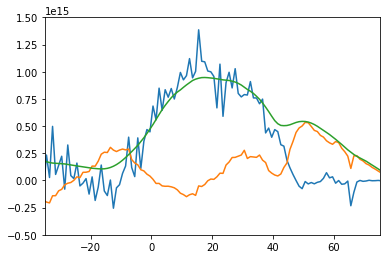

In [14]:
plt.plot(dsV.lat, Hov)
plt.plot(dsV.lat, Haz)
if experiment == 'Eoi400':
    plt.plot(dsOHT.lat, dsOHT.impl_mer_heat_transport_Plio_AtlArc[0,:,0])
else: 
    plt.plot(dsOHT.lat, dsOHT.impl_mer_heat_transport_PI_AtlArc[0,:,0])
plt.xlim([-35,75])
plt.ylim([-0.5e15, 1.5e15])

(-500000000000000.0, 1500000000000000.0)

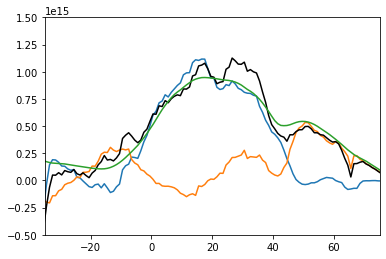

In [15]:
#Use a 5 degree running mean filter to smooth output
N=5
Hov_smoothed = np.convolve(Hov, np.ones(N)/N, mode='same')
Haz_smoothed = Haz #np.convolve(Haz, np.ones(N)/N, mode='same')

plt.plot(dsV.lat, Hov_smoothed)
plt.plot(dsV.lat, Haz_smoothed)
plt.plot(dsV.lat, Hov_smoothed+Haz_smoothed, color='black')
if experiment == 'Eoi400':
    plt.plot(dsOHT.lat, dsOHT.impl_mer_heat_transport_Plio_AtlArc[0,:,0])
else: 
    plt.plot(dsOHT.lat, dsOHT.impl_mer_heat_transport_PI_AtlArc[0,:,0])
plt.xlim([-35,75])
plt.ylim([-0.5e15, 1.5e15])

In [16]:
dsE = xr.Dataset(data_vars = dict(OHTov=(["lat"], Hov_smoothed/1e15), OHTaz=(["lat"], Haz_smoothed/1e15)), coords = dict(lat = dsV.lat.values))
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomOHT_100yr.nc')

## 100-yr average AMOC

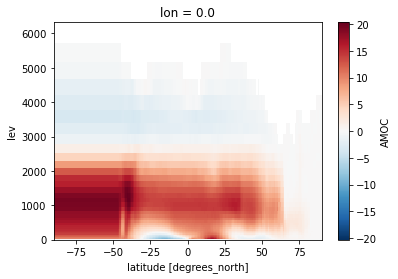

In [17]:
#Mask (almost) zero values 
a = dsMOC.AMOC[:,:,:,0].mean(dim='time')
b = a.where(a<-1e-6).fillna(0)+a.where(a>1e-6).fillna(0)
c = b.where(b!=0)
c.plot()

In [18]:
dsM = xr.Dataset(data_vars = dict(AMOC=(("z","lat"), c.values)), coords = dict(z = dsMOC.lev.values, lat = dsMOC.lat.values))
xr.Dataset.to_netcdf(dsM, path = datafolder+'/Processed/'+model+'/'+experiment+'/AMOC_100yr.nc')

## Annual AMOC streamfunction (100 years)

In [19]:
#Mask (almost) zero values 
a = dsMOC.AMOC[:,:,:,0]
b = a.where(a<-1e-6).fillna(0)+a.where(a>1e-6).fillna(0)
c = b.where(b!=0)

In [20]:
dsM2 = xr.Dataset(data_vars = dict(AMOC=(("time","z","lat"), c.values)), coords = dict(time = np.arange(2650, 2750), z = dsMOC.lev.values, lat = dsMOC.lat.values))
xr.Dataset.to_netcdf(dsM2, path = datafolder+'Processed/'+model+'/'+experiment+'/AMOC_annual_100yr.nc')

## 100-yr mean total Atlantic OHT

In [21]:
#Total Atlantic OHT computed from OHTov+OHTaz
dsH = xr.Dataset(data_vars = dict(OHT=(("lat"), (Hov_smoothed+Haz_smoothed)/1e15)), coords = dict(lat = dsV.lat.values))
xr.Dataset.to_netcdf(dsH, path = datafolder+'Processed/'+model+'/'+experiment+'/OHT_100yr.nc')

In [22]:
# Indirectly calculated OHT from surface heat fluxes
if experiment == 'E280':
    dsH = xr.Dataset(data_vars = dict(OHT=(("lat"), (dsOHT.impl_mer_heat_transport_PI_AtlArc[0,:,0]/1e15).values)), coords = dict(lat = dsOHT.lat.values))
    xr.Dataset.to_netcdf(dsH, path = datafolder+'Processed/'+model+'/'+experiment+'/OHT_100yr_impl.nc')
elif experiment == 'Eoi400':
    dsH = xr.Dataset(data_vars = dict(OHT=(("lat"), (dsOHT.impl_mer_heat_transport_Plio_AtlArc[0,:,0]/1e15).values)), coords = dict(lat = dsOHT.lat.values))
    xr.Dataset.to_netcdf(dsH, path = datafolder+'Processed/'+model+'/'+experiment+'/OHT_100yr_impl.nc')

## Annual SST timeseries (100 years)

In [23]:
dstos = xr.open_dataset(folder+experiment+'/COSMOS_'+experiment+'.SST.timeseries_no_ann_cycle.nc', decode_times=False)
dsclim = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)

tos = dstos.tos
tosann = np.zeros([100,180,360])

for i in range(0,100):
    tosann[i] = tos[0+i*12:12+i*12].mean(dim='time')

dsSST1 = xr.Dataset(data_vars = dict(sst=(("time","latitude","longitude"), tosann)), coords = dict(time = np.arange(2650, 2750), latitude = tos.latitude.values, longitude = tos.longitude.values))
tosann = dsSST1.sst+dsclim.tos.mean(dim='month')

dsSST = xr.Dataset(data_vars = dict(sst=(("time","lat","lon"), tosann)), coords = dict(time = np.arange(2650, 2750), lat = tos.latitude.values, lon = tos.longitude.values))
xr.Dataset.to_netcdf(dsSST, path = datafolder+'Processed/'+model+'/'+experiment+'/SST_annual_100yr.nc')

## 100-yr mean SSS (regridded)

In [24]:
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)

regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)
sss = regridder(dsS.so[0,0])

dsSSS = xr.Dataset(data_vars = dict(sss=(("lat","lon"), sss)), coords = dict(lat = sss.latitude.values, lon = sss.longitude.values))
xr.Dataset.to_netcdf(dsSSS, path = datafolder+'Processed/'+model+'/'+experiment+'/SSS_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean sea ice

In [25]:
dsi = dsice.drop('time') # To avoid error with adding different months together

djf = (dsi.sic[11:1200:12]+dsi.sic[0:1200:12]+dsi.sic[1:1200:12])/3
si_djf = djf.mean(dim='time')

mam = (dsi.sic[2:1200:12]+dsi.sic[3:1200:12]+dsi.sic[4:1200:12])/3
si_mam = mam.mean(dim='time')

jja = (dsi.sic[5:1200:12]+dsi.sic[6:1200:12]+dsi.sic[7:1200:12])/3
si_jja = jja.mean(dim='time')

son = (dsi.sic[8:1200:12]+dsi.sic[9:1200:12]+dsi.sic[10:1200:12])/3
si_son = son.mean(dim='time')

si = (si_djf+si_mam+si_jja+si_son)/4

dsSI = xr.Dataset(data_vars = dict(si_djf=(("lat","lon"), si_djf), si_mam = (("lat","lon"), si_mam), si_jja = (("lat","lon"), si_jja), si_son = (("lat","lon"), si_son), si_mean = (("lat","lon"), si)), coords = dict(lat = si_djf.lat.values, lon = si_djf.lon.values))
xr.Dataset.to_netcdf(dsSI, path = datafolder+'Processed/'+model+'/'+experiment+'/SI_100yr.nc')

## 100-yr mean top 100 m salinity

In [32]:
#Function to make a dz array for weighting
def makedz(z):
    dz = np.zeros(len(z))
    dz[0] = z[0].values*2
    depth = dz[0]
    for i in range(1,len(z)):
        dz[i] = (z[i]-depth)*2
        depth = depth+dz[i] #Depth spacing. Units: cm
    return xr.DataArray(data=dz, dims=("lev"))

regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)
weights = makedz(dsS.lev[0:8])

s100m = regridder(dsS.so[0,0:8].weighted(weights).mean(dim='lev'))

dsS100m = xr.Dataset(data_vars = dict(s100m=(("lat","lon"), s100m)), coords = dict(lat = s100m.latitude.values, lon = s100m.longitude.values))
xr.Dataset.to_netcdf(dsS100m, path = datafolder+'Processed/'+model+'/'+experiment+'/so100m_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr zonal mean salinity

In [33]:
salt_atl = dsS.so[0]

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

salt = regridder(salt_atl)
mask = regularAtlmask(salt)

salt_zm = salt.where(mask>-1).mean(dim='longitude')

dszm = xr.Dataset(data_vars = dict(so=(("z","lat"), salt_zm)), coords = dict(z = salt_zm.lev.values, lat = salt_zm.latitude.values))
xr.Dataset.to_netcdf(dszm, path = datafolder+'Processed/'+model+'/'+experiment+'/so_zm_100yr.nc')

## 100-yr zonal mean temperature

In [34]:
temp_atl = dsT.thetao[0]

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsT, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

temp = regridder(temp_atl)
mask = regularAtlmask(temp)

temp_zm = temp.where(mask>-1).mean(dim='longitude')
dtzm = xr.Dataset(data_vars = dict(thetao=(("z","lat"), temp_zm)), coords = dict(z = temp_zm.lev.values, lat = temp_zm.latitude.values))
xr.Dataset.to_netcdf(dtzm, path = datafolder+'Processed/'+model+'/'+experiment+'/thetao_zm_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean wind at 1000 hPa

In [36]:
folder = datafolder+'Raw_data/'+model+'/'+experiment+'/'

In [37]:
if experiment =='E280':
    dsu = xr.open_dataset(folder+'Atm/E280.ua_2650-2749_monthly_climatology.nc')
    dsv = xr.open_dataset(folder+'Atm/E280.va_2650-2749_monthly_climatology.nc')
else:
    dsu = xr.open_dataset(folder+'Atm/Eoi400.ua_2650-2749_monthly_climatology.nc')
    dsv = xr.open_dataset(folder+'Atm/Eoi400.va_2650-2749_monthly_climatology.nc')

In [38]:
ua = dsu.ua.mean(dim='time')[0]
va = dsv.va.mean(dim='time')[0]

In [39]:
dsgrid = xr.open_dataset(folder+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsu, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

u = regridder(ua)
v = regridder(va)

dsUV = xr.Dataset(data_vars = dict(ua=(("lat","lon"), u), va=(("lat","lon"), v)), coords = dict(lat = u.latitude.values, lon = v.longitude.values))
xr.Dataset.to_netcdf(dsUV, path = datafolder+'Processed/'+model+'/'+experiment+'/UVa_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
